In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import tangram as tg

In [2]:
# import squidpy as sq
# from anndata import AnnData
# import pathlib
# import matplotlib as mpl
# import skimage
# import seaborn as sns

# sc.logging.print_header()
# print(f"squidpy=={sq.__version__}")

# %load_ext autoreload
# %autoreload 2

In [3]:
# # https://www.nature.com/articles/s41467-022-35297-z#data-availability

# exp = pd.read_csv('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/human_kidney_scRNA/exprMatrix.tsv.gz', sep='\t', compression='gzip', index_col=0)
# adata_sc = sc.AnnData(exp.T)
# adata_sc

In [4]:
# metadata = pd.read_csv('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/human_kidney_scRNA/meta.tsv', sep='\t', index_col=0)
# adata_sc.obs = metadata.loc[adata_sc.obs_names]

In [5]:
# print(adata_sc.obs.columns)
# adata_sc.obs.head(3)

In [6]:
# adata_sc.obs['Cell_Types_Subclusters'].value_counts()

In [2]:
adata_st = sc.read_10x_mtx('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/binned_outputs/square_008um/filtered_feature_bc_matrix')
spatial = pd.read_parquet('/ix3/djishnu/alw399/SpaceOracle/data/human_kidney_visiumHD/binned_outputs/square_008um/spatial/tissue_positions.parquet')

barcodes = list(set(adata_st.obs_names) & set(spatial['barcode'].values))
adata_st = adata_st[barcodes, :]

spatial.set_index('barcode', inplace=True)
adata_st.obs = spatial.loc[barcodes]
adata_st.obsm['spatial'] = spatial[['pxl_row_in_fullres', 'pxl_col_in_fullres']].loc[barcodes].values

adata_st

AnnData object with n_obs × n_vars = 666694 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'

In [3]:
adata_st.layers['raw_count'] = adata_st.X.copy()

In [4]:
adata_st.X = adata_st.layers['raw_count'].copy()

sc.pp.normalize_total(adata_st, target_sum=1e4)
# sc.pp.log1p(adata_st) # Dont do this yet because we groupby when translating human to mouse

adata_st.layers['normalized_count'] = adata_st.X.copy()

In [5]:
sc.pp.filter_cells(adata_st, min_genes=80)
adata_st

AnnData object with n_obs × n_vars = 291494 × 18085
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes'
    var: 'gene_ids', 'feature_types'
    obsm: 'spatial'
    layers: 'raw_count', 'normalized_count'

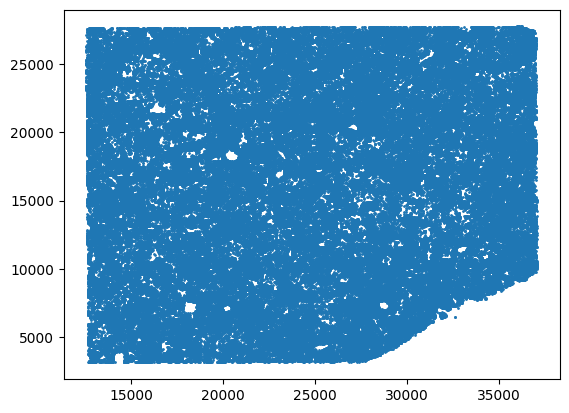

In [6]:
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], s=1, alpha=1)

In [7]:
adata_sc = sc.read_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/mouse_kidney_13.h5ad')
adata_sc

AnnData object with n_obs × n_vars = 8509 × 3058
    obs: 'ct1', 'ct2', 'ct3', 'ct4', 'cond', 'medulla_cortex', 'domain', 'cell_type', 'cell_type_int'
    uns: 'cell_thresholds', 'cell_type_colors', 'neighbors', 'pca', 'received_ligands', 'received_ligands_tfl', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_unscaled'
    varm: 'PCs'
    layers: 'imputed_count', 'normalized_count', 'raw_count'
    obsp: 'connectivities', 'distances'

In [8]:
# https://github.com/stefanpeidli/mousipy/blob/main/src/mousipy/biomart/human_to_mouse.csv

h2m = pd.read_csv('/ix3/djishnu/alw399/SpaceOracle/data/human_to_mouse.csv')
h2m = h2m[(h2m['Gene name'].notna()) & (h2m['Mouse gene name'].notna())]
h2m.head(2)

,Gene stable ID,Gene name,Mouse gene name,Mouse gene stable ID,Mouse homology type,"Mouse orthology confidence [0 low, 1 high]",Mouse Gene-order conservation score
5,ENSG00000198888,MT-ND1,mt-Nd1,ENSMUSG00000064341,ortholog_one2one,1.0,50.0
9,ENSG00000198763,MT-ND2,mt-Nd2,ENSMUSG00000064345,ortholog_one2one,1.0,75.0


In [9]:
h2m = h2m[h2m['Mouse gene name'].isin(adata_sc.var_names)]
h2m = h2m[h2m['Gene name'].isin(adata_st.var_names)]
h2m.head(2)

,Gene stable ID,Gene name,Mouse gene name,Mouse gene stable ID,Mouse homology type,"Mouse orthology confidence [0 low, 1 high]",Mouse Gene-order conservation score
531,ENSG00000154620,TMSB4Y,Tmsb4x,ENSMUSG00000049775,ortholog_one2one,1.0,0.0
1276,ENSG00000166265,CYYR1,Cyyr1,ENSMUSG00000041134,ortholog_one2one,1.0,100.0


In [10]:
mouse_gex = []
mouse_gex_log = []
mouse_genes = []

gex_columns = list(set(adata_st.var_names) & set(h2m['Gene name']))
gex = adata_st.to_df()[gex_columns]
gex_log = adata_st.to_df(layer='normalized_count')[gex_columns]

for human_gene in tqdm(gex_columns, total=len(gex_columns)):
    mapping = h2m[h2m['Gene name'] == human_gene]

    # If there are many mouse genes that this human gene corresponds to,
    # we will set all mouse gene expression to the same value
    if len(mapping) > 1:

        for i, row in mapping.iterrows():
            mouse_genes.append(row['Mouse gene name'])
            mouse_gex.append(gex[human_gene].values)
            mouse_gex_log.append(gex_log[human_gene].values)

    else:
        mouse_genes.append(mapping['Mouse gene name'].item())
        mouse_gex.append(gex[human_gene].values)
        mouse_gex_log.append(gex_log[human_gene].values)


100%|██████████| 2830/2830 [00:00<00:00, 3084.18it/s]


In [11]:
df = pd.DataFrame(mouse_gex, index=mouse_genes, columns=adata_st.obs_names)
df = df.T 

df_log = pd.DataFrame(mouse_gex_log, index=mouse_genes, columns=adata_st.obs_names)
df_log = df_log.T

In [12]:
# If there are duplicate mouse gene names, that means there is more than one
# human gene mapped to a mouse gene. 
# Then, we take the average expression of the human genes

df = df.groupby(df.columns, axis=1).mean()
df = df.reindex(adata_sc.var_names, axis=1).fillna(0)

df_log = df_log.groupby(df_log.columns, axis=1).mean()
df_log = df_log.reindex(adata_sc.var_names, axis=1).fillna(0)

df_log.head(3)

,Sox17,St18,Prex2,Lactb2,Kcnb2,Stau2,Pi15,Crispld1,Tfap2b,Pkhd1,...,Gpm6b,Ofd1,Egfl6,Tmsb4x,Tlr8,Tlr7,Frmpd4,Arhgap6,Amelx,Mid1
barcode,,,,,,,,,,,,,,,,,,,,,
s_008um_00608_00701-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_008um_00724_00001-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
s_008um_00137_00747-1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
tmp = sc.AnnData(
    X = df.values,
    obs = adata_st.obs,
    obsm = adata_st.obsm,
    var = pd.DataFrame(index=df.columns),
    layers = {
        'raw_count': df.values
    }
)

tmp.X = df_log.values
sc.pp.log1p(tmp)
tmp.layers['normalized_count'] = tmp.X

tmp, tmp.var_names

(AnnData object with n_obs × n_vars = 291494 × 3058
     obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes'
     uns: 'log1p'
     obsm: 'spatial'
     layers: 'raw_count', 'normalized_count',
 Index(['Sox17', 'St18', 'Prex2', 'Lactb2', 'Kcnb2', 'Stau2', 'Pi15',
        'Crispld1', 'Tfap2b', 'Pkhd1',
        ...
        'Gpm6b', 'Ofd1', 'Egfl6', 'Tmsb4x', 'Tlr8', 'Tlr7', 'Frmpd4', 'Arhgap6',
        'Amelx', 'Mid1'],
       dtype='object', length=3058))

In [14]:
tmp.write('mousified_adata.h5ad')

In [15]:
adata_st = tmp.copy()

In [16]:
[x for x in adata_sc.var_names if not x[0].isupper()]

['ccdc198']

In [17]:
adata_sc.X = adata_sc.layers['normalized_count']

In [18]:
celltypes = adata_sc.obs['ct3'].unique()

# ct3 is finer resolution than cell_types, which CO GRN and COMMOT LRs use

mapping = {}
for ct3 in celltypes:
    value = adata_sc[adata_sc.obs['ct3'] == ct3].obs['cell_type'].drop_duplicates().iloc[0]
    mapping[ct3] = value

adata_sc.obs['cell_type'].value_counts()

cell_type
Myeloid                5266
Endothelial            1779
Epithelial              462
B                       442
T                       361
Mesenchymal_Stromal     128
NK                       71
Name: count, dtype: int64

In [19]:
adata_sc.X.max(), adata_st.X.max()

(7.434651, 8.675968873697643)

In [20]:
sc.tl.rank_genes_groups(adata_sc, groupby="ct3", use_raw=False, layer='normalized_count')
markers_df = pd.DataFrame(adata_sc.uns["rank_genes_groups"]["names"]).iloc[0:100, :]
hv_markers = list(np.unique(markers_df.melt().value.values))
len(hv_markers)

1748

In [21]:
import decoupler as dc

markers = dc.get_resource(
    name='PanglaoDB',
    organism='mouse',
    license='academic'
)
markers = markers[markers['mouse'].astype(bool) & markers['canonical_marker'].astype(bool) & (markers['mouse_sensitivity'].astype(float) > 0.5)]
markers = markers[~markers.duplicated(['cell_type', 'genesymbol'])]
markers = markers[markers['organ'] == 'Kidney']
kidney_markers = markers['genesymbol'].values
len(kidney_markers)

64

In [22]:
markers = list(set(hv_markers) | set(kidney_markers))
len(markers)

1766

In [23]:
tg.pp_adatas(adata_sc, adata_st, genes=markers)


1625 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
2802 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.


In [24]:
ad_map = tg.map_cells_to_space(adata_sc, adata_st,
    # mode="cells",
    mode="clusters",
    # cluster_label='cell_type',  # .obs field w cell types
    cluster_label='ct3',  # .obs field w cell types
    density_prior='rna_count_based',
    num_epochs=500,
    device="cuda:0",
    # device='cpu',
    # device='mps'
)

Allocate tensors for mapping.
Begin training with 1625 genes and rna_count_based density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.088, KL reg: 0.130
Score: 0.163, KL reg: 0.001
Score: 0.168, KL reg: 0.001
Score: 0.170, KL reg: 0.001
Score: 0.170, KL reg: 0.001


Saving results..


In [25]:
# tg.project_cell_annotations(ad_map, adata_st, annotation="Cell_Types_Subclusters")
tg.project_cell_annotations(ad_map, adata_st, annotation="ct3") 


spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


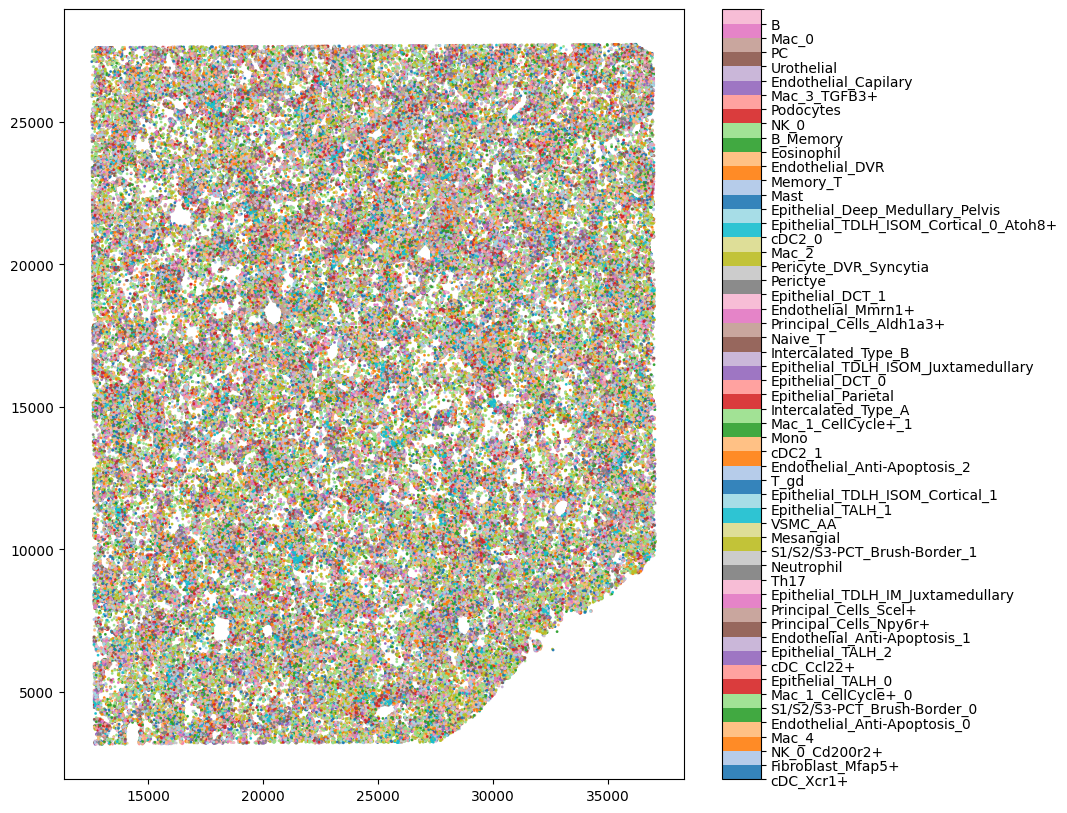

In [26]:
%matplotlib inline
import seaborn as sns
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['predicted'].unique()
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['predicted'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

plt.figure(figsize=(10,10))
# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()


In [27]:
adata_st.obs['predicted'].value_counts()

predicted
S1/S2/S3-PCT_Brush-Border_0               13446
S1/S2/S3-PCT_Brush-Border_1               11452
Epithelial_DCT_1                           7941
Epithelial_TALH_1                          7898
Epithelial_DCT_0                           7497
Epithelial_TDLH_IM_Juxtamedullary          7473
Principal_Cells_Npy6r+                     7473
Epithelial_TALH_0                          7372
B_Memory                                   7360
Mac_4                                      7316
Pericyte_DVR_Syncytia                      6936
Eosinophil                                 6919
VSMC_AA                                    6814
Endothelial_Anti-Apoptosis_1               6802
Epithelial_Parietal                        6743
Mesangial                                  6670
Mac_1_CellCycle+_1                         6579
Intercalated_Type_B                        6552
Perictye                                   6449
Epithelial_TDLH_ISOM_Cortical_0_Atoh8+     6427
Epithelial_TDLH_ISOM_Juxtamedu

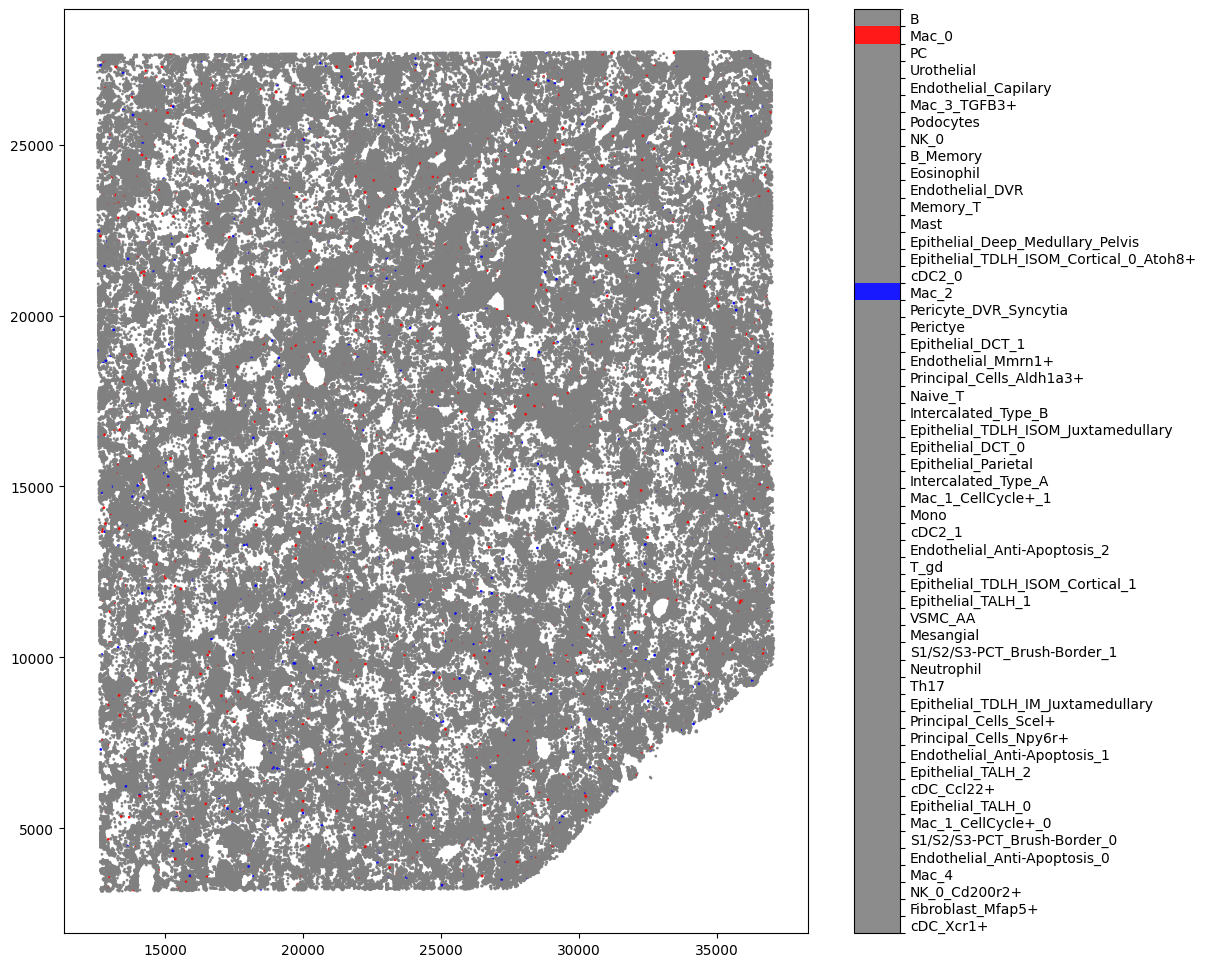

In [28]:
plt.figure(figsize=(12, 12))
unique_cell_types = adata_st.obs['predicted'].unique()
adata_st.obs['predicted'] = adata_st.obsm['tangram_ct_pred'].idxmax(axis=1)

cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['predicted'].map(cell_type_to_numeric)

colors = ['gray'] * len(unique_cell_types)
if 'Mac_0' in cell_type_to_numeric:
    colors[cell_type_to_numeric['Mac_0']] = 'red'
if 'Mac_2' in cell_type_to_numeric:
    colors[cell_type_to_numeric['Mac_2']] = 'blue'
cmap = ListedColormap(colors)
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types )

for label in cbar.ax.get_yticklabels():
    label.set_verticalalignment('bottom')  # Change alignment
    label.set_y(label.get_position()[1] + 0.05)  # Adjust y-position (move up)

plt.show()


In [29]:
adata_st.obs['ct3'] = adata_st.obs['predicted']
adata_st.obs['cell_type'] = adata_st.obs['ct3'].map(mapping)
adata_st.obs['cell_type'].value_counts()

cell_type
Epithelial             129419
Myeloid                 56250
Mesenchymal_Stromal     33023
Endothelial             32785
T                       19169
B                       12656
NK                       8192
Name: count, dtype: int64

In [30]:
adata_sc.obs['cell_type'].value_counts()

cell_type
Myeloid                5266
Endothelial            1779
Epithelial              462
B                       442
T                       361
Mesenchymal_Stromal     128
NK                       71
Name: count, dtype: int64

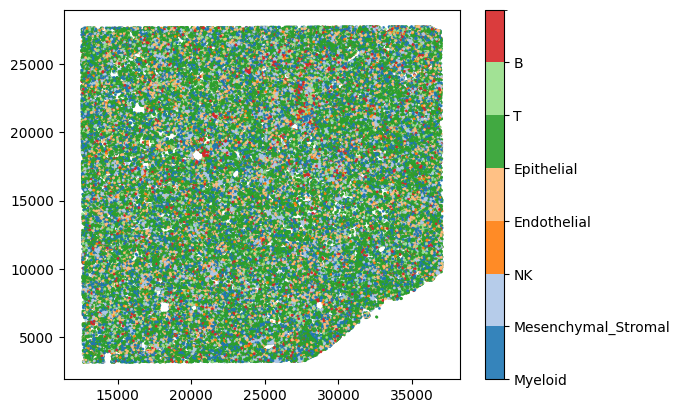

In [31]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
unique_cell_types = adata_st.obs['cell_type'].unique()

# Create a numeric representation of the predicted cell types
cell_type_to_numeric = {cell_type: idx for idx, cell_type in enumerate(unique_cell_types)}
adata_st.obs['predicted_numeric'] = adata_st.obs['cell_type'].map(cell_type_to_numeric)

from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a colormap and norm
cmap = ListedColormap(sns.color_palette("tab20", len(unique_cell_types)).as_hex())
norm = BoundaryNorm(range(len(unique_cell_types) + 1), cmap.N)

# Plot the scatter plot
plt.scatter(adata_st.obsm['spatial'][:, 0], adata_st.obsm['spatial'][:, 1], 
            c=adata_st.obs['predicted_numeric'], s=1, alpha=0.9, cmap=cmap, norm=norm)

# Create a color bar with cell type labels
cbar = plt.colorbar(ticks=range(len(unique_cell_types)))
cbar.ax.set_yticklabels(unique_cell_types)

plt.show()


In [32]:
import sys
sys.path.append('../../src')
from spaceoracle.tools.utils import clean_up_adata
from spaceoracle.tools.network import encode_labels
from spaceoracle.tools.utils import scale_adata

adata_st = scale_adata(adata_st, cell_size=8)
adata_st


AnnData object with n_obs × n_vars = 291494 × 2802
    obs: 'in_tissue', 'array_row', 'array_col', 'pxl_row_in_fullres', 'pxl_col_in_fullres', 'n_genes', 'uniform_density', 'rna_count_based_density', 'predicted', 'predicted_numeric', 'ct3', 'cell_type'
    var: 'n_cells', 'sparsity'
    uns: 'log1p', 'training_genes', 'overlap_genes'
    obsm: 'spatial', 'tangram_ct_pred', 'spatial_unscaled'
    layers: 'raw_count', 'normalized_count'

In [33]:
adata_st.obs['cell_type'] = adata_st.obs['cell_type'].astype('category')
adata_st.obs['cell_type_int'] = adata_st.obs['cell_type'].apply(
    lambda x: encode_labels(adata_st.obs['cell_type'], reverse_dict=True)[x])


In [34]:
clean_up_adata(adata_st, ['cell_type', 'cell_type_int', 'spatial', 'ct3'])
adata_st


AnnData object with n_obs × n_vars = 291494 × 2802
    obs: 'ct3', 'cell_type', 'cell_type_int'
    obsm: 'spatial', 'tangram_ct_pred', 'spatial_unscaled'
    layers: 'raw_count', 'normalized_count'

In [35]:
adata_st.write_h5ad('annotated.h5ad')

In [36]:
from spaceoracle.oracles import BaseTravLR
from spaceoracle.tools.utils import scale_adata

pcs = BaseTravLR.perform_PCA(adata_st)
BaseTravLR.knn_imputation(adata_st, pcs, method='MAGIC')


Calculating MAGIC...
  Running MAGIC on 291494 cells and 2802 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...
    Calculated PCA in 12.53 seconds.
    Calculating KNN search...


In [ ]:
adata_st.write_h5ad('/ix/djishnu/shared/djishnu_kor11/training_data_2025/human_kidney_visium.h5ad')